In [4]:
from typing import List, Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import tool
from langchain_exa import ExaSearchRetriever
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display



def retrieve_web_content(query: str) -> List[str]:
    """Function to retrieve usable documents for AI assistant"""
    # Initialize the Exa Search retriever
    retriever = ExaSearchRetriever(k=3, highlights=True, use_autoprompt=True)

    # Define how to extract relevant metadata from the search results
    document_prompt = PromptTemplate.from_template(
        """
    <source>
        <url>{url}</url>
        <highlights>{highlights}</highlights>
    </source>
    """
    )

    # Create a chain to process the retrieved documents
    document_chain = (
        RunnableLambda(
            lambda document: {
                "highlights": document.metadata.get("highlights", "No highlights"),
                "url": document.metadata["url"],
            }
        )
        | document_prompt
    )

    # Execute the retrieval and processing chain
    retrieval_chain = retriever | document_chain.map()

    # Retrieve and return the documents
    documents = retrieval_chain.invoke(query)
    return documents


# Define and bind the AI model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(
    [retrieve_web_content]
)


# Determine whether to continue or end
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    return "tools" if last_message.tool_calls else END


# Function to generate model responses
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


# Define the workflow graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode([retrieve_web_content]))
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

# Initialize memory
checkpointer = MemorySaver()

# Compile the workflow into a runnable
app = workflow.compile(checkpointer=checkpointer)

final_state = app.invoke(
    {
        "messages": [
            HumanMessage(content="Latest research papers on climate technology")
        ]
    },
    config={"configurable": {"thread_id": 44}},
)
print(final_state["messages"][-1].content)

Here are some of the latest research papers on climate technology:

1. **Title:** [European Green Deal and Net-Zero Emissions](https://www.nature.com/articles/s41467-024-52424-0)
   - **Highlights:** This paper discusses the European Union's ambitious goal of achieving net-zero greenhouse gas emissions by 2050, the challenges of implementing various policy measures, and the interplay between technology options and social acceptance.

2. **Title:** [RC Systems for Energy and Environment Challenges](https://arxiv.org/abs/2410.04109)
   - **Highlights:** This research assesses the trade-offs between design and practical application for RC (Resource Conservation) systems, promoting RC-based technologies to address global energy and environmental challenges.

3. **Title:** [Geoengineering Discussion](https://x.com/geoengineering1/status/1842468004635844816)
   - **Highlights:** This source appears to be a conversation related to geoengineering, providing insights into ongoing discussions in

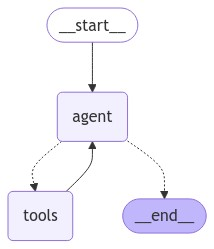

In [5]:
display(Image(app.get_graph(xray = True).draw_mermaid_png()))